In [1]:
import brainstate as bst
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from Brain_state import Coupled_Net, GOP_decoding, circ_dis
bst.environ.set(dt=0.2, platform='cpu')  # length of time step
import time


/Users/chutianhao/opt/anaconda3/envs/bp311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 开始计时
start_time = time.time()



# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi

# input_strength
alpha_p = 0.05
alpha_g = 0.05
noise_ratio = 0.007
neural_noise_sigma = 0.2
trial_num = 500
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20


@jax.jit
@bst.transform.jit
def run_a_trial(key):
  bst.random.DEFAULT.seed(key)

  final_model = Coupled_Net(num_module=M)
  bst.init_states(final_model)

  z_truth = 30
  phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi
  z_e = z_truth
  psi = phi_truth + sigma_phi * bst.random.randn((M))
  Ig = jnp.zeros((M, num_g))
  for j in range(M):
    dis_theta = circ_dis(theta, psi[j])
    Ig = Ig.at[j].set(jnp.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * bst.random.randn(num_g))

  x = np.linspace(0, L, num_p, endpoint=False)
  dis_x = x - z_e
  Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * bst.random.randn(num_p)
  z_decode_n, _, up, rp, ug, rg = final_model.Net_decoding(z_truth, phi_truth, Ip, Ig)

  max_up = jnp.max(up, axis=1)
  max_rp = jnp.max(rp, axis=1)
  Ap = jnp.max(max_up[-1])
  Rp = jnp.max(max_rp[-1])
  Ag = jnp.zeros(M)
  Rg = jnp.zeros(M, )
  for mi in range(M):
    max_ug = jnp.max(ug[:, mi, :], axis=1)
    max_rg = jnp.max(rg[:, mi, :], axis=1)
    Ag = Ag.at[mi].set(jnp.max(max_ug[-1]))
    Rg = Rg.at[mi].set(jnp.max(max_rg[-1]))
  z_decode_g = GOP_decoding(z_t=z_truth, phi_t=phi_truth, Ip=Ip, Ig=Ig,
                            alpha_p_infer=0.05, alpha_g_infer=0.05,
                            Ap=Ap, Rp=Rp, Ag=Ag)

  return z_decode_g, z_decode_n[-1]


In [3]:

key = jax.random.PRNGKey(1)
z_decode_gop, z_decode_net = jax.vmap(run_a_trial)(jax.random.split(key, trial_num))
z_decode_all = np.concatenate([z_decode_gop, z_decode_net])

end_time = time.time()

# 计算运行时间
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 29.40383005142212 seconds


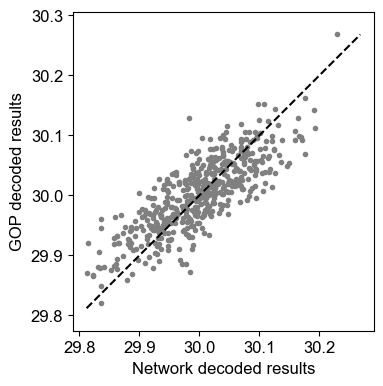

In [4]:

# 设置字体
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# 画图
plt.figure(figsize=(4, 4))
z_decode_all = np.concatenate([z_decode_gop, z_decode_net])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

plt.plot(z_decode_net, z_decode_gop, '.', color='gray')
plt.plot([min_z, max_z], [min_z, max_z], 'k--')
plt.xlabel('Network decoded results')
plt.ylabel('GOP decoded results')
plt.axis('equal')  # 设置坐标轴比例相等
plt.tight_layout()
plt.savefig('net_gop_comparison.png')
plt.show()